In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import tensorflow as tf

from tensorflow.keras.models import Model,Sequential, load_model,model_from_json
from tensorflow.compat.v1.keras.backend import set_session 
from PIL import Image
from PIL import Image
from torchvision import transforms

# Importar módulo facial_analysis.py
from facial_analysis import FacialImageProcessing

from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

class FacialEmotionRecognition:
    
    def __init__(self):
        
        %env CUDA_VISIBLE_DEVICES=0
        
        # Configuración de la sesión
        config = tf.compat.v1.ConfigProto()
        config.gpu_options.allow_growth = True
        sess=tf.compat.v1.Session(config=config)
        set_session(sess)

        # Comprobar si hay cuda o si se ha de usar la cpu
        self.use_cuda = torch.cuda.is_available()
        print("Cuda: ", self.use_cuda)
        self.device = 'cuda' if self.use_cuda else 'cpu'

        # Utilización modelo de procesado de la imagen
        self.imgProcessing = FacialImageProcessing(False)
                        
        # El modelo escogido es enet_b2_7.pt, que predice las 7 emociones básicas
        NUM_EMOTIONS = 7
        self.IMG_SIZE = 260
#         models_path,_ = os.path.split(os.path.realpath(__file__))
        PATH=os.path.join('models','affectnet_emotions','enet_b2_7.pt')
        self.idx_to_class = {0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Neutral', 5: 'Sadness', 6: 'Surprise'}

        # Transformar la imagen a tensor para hacer inferencia
        self.test_transforms = transforms.Compose(
            [
                transforms.Resize((self.IMG_SIZE, self.IMG_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
            ]
        )
        # print(PATH)
        self.model = torch.load(PATH,map_location=torch.device(self.device)) # Cargar el modelo en la cpu
        self.model = self.model.to(self.device)
        # model.eval()
        
    def FramePrediction(self, frame=None, heat_map=False):
        
        scores = []
        max_score = []
        
        # Comprobar si hay frame
        if frame is not None:
            
            # Predicción de las caras de la imagen y plot de las mismas junto a sus predicciones
            frame_bgr=frame
            # plt.figure(figsize=(5, 5))
            frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
            # plt.axis('off')
            # plt.imshow(frame)
            bounding_boxes, points = self.imgProcessing.detect_faces(frame)
            points = points.T
            
            cont_faces = 1
            
            # Comprobar si hay caras
            if bounding_boxes.any(): 

                for bbox,p in zip(bounding_boxes, points):
                    box = bbox.astype(np.int)
                    x1,y1,x2,y2=box[0:4]    
                    face_img=frame[y1:y2,x1:x2,:]

                    img_tensor = self.test_transforms(Image.fromarray(face_img))
                    img_tensor.unsqueeze_(0)
                    scores = self.model(img_tensor.to(self.device))
                    scores=scores[0].data.cpu().numpy()
                    max_score=self.idx_to_class[np.argmax(scores)]
                    
                    plt.figure(figsize=(3, 3))
                    plt.axis('off')
                    plt.imshow(face_img)
                    plt.title(max_score)
                    print("Score cara {}: ".format(cont_faces),scores)
                    plt.show()

                    cont_faces = cont_faces+1

                    # Para ver el mapa de calor
                    if heat_map == True:

                        # Para ver el mapa de calor (GradCAM), que ayuda a detectar las regiones 
                        # consideradas importantes por la red neuronal para realizar la predicción

                        target_layers = [self.model.blocks[-1][-1]]
                        # Construct the CAM object once, and then re-use it on many images:
                        cam = GradCAM(model=self.model, target_layers=target_layers, use_cuda=self.use_cuda)

                        grayscale_cam = cam(input_tensor=img_tensor)
                        grayscale_cam = grayscale_cam[0, :]
                        face_img=cv2.resize(face_img,(self.IMG_SIZE, self.IMG_SIZE))
                        rgb_img = np.float32(face_img) / 255
                        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

                        plt.figure(figsize=(3, 3))
                        plt.axis('off')
                        plt.imshow(visualization)
                        plt.title(max_score)  
                        plt.show()
                                      
            # Si no hay caras
            else: print("There is no faces!")
           
        # Si no hay imagen (frame)
        else: print("There is no image!")
            
        return scores, max_score            

In [2]:
import pandas as pd
import os 
import numpy as np
import matplotlib.pyplot as plt
import cv2

def PlotEmotions(currentframe=None, max_scores=None):
    # Crear gráfica de variación de emociones a lo largo de un vídeo
    
    if currentframe and max_scores:
        # En x los frames
        x = np.array(range(currentframe))
        # En y las emociones 
        y = np.array(max_scores)

        plt.figure(figsize=(8,4))
        plt.ylim(-0.5,6.5)
        plt.plot(x,y, 's--r')
        plt.xlabel("Frames")
        plt.ylabel("Emotion")
        plt.show()
        # Donde:
        # {0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Neutral', 5: 'Sadness', 6: 'Surprise'} 
    else:
        print("There is no data!")
    
def PlotEmotionsVariation(scores=None):
    
    if scores:
        emotion_scores = [[],[],[],[],[],[],[]]

        for i in range(7):
            for j in range(len(scores)):  
                emotion_scores[i].append(scores[j][i]) 

        # DataFrame
        data = {0: emotion_scores[0], 1: emotion_scores[1], 2: emotion_scores[2], 3: emotion_scores[3],
               4: emotion_scores[4], 5: emotion_scores[5], 6: emotion_scores[6]}
        df = pd.DataFrame(data)
        df.head()

        # Variación intra-emoción
        data_ar = np.array(df)

        plt.figure(figsize=(10,5))
        plt.plot(data_ar[:,0],'s--r',linewidth=1,color='b')
        plt.plot(data_ar[:,1],'s--r',linewidth=1,color='r')
        plt.plot(data_ar[:,2],'s--r',linewidth=1,color='g')
        plt.plot(data_ar[:,3],'s--r',linewidth=1,color='c')
        plt.plot(data_ar[:,4],'s--r',linewidth=1,color='m')
        plt.plot(data_ar[:,5],'s--r',linewidth=1,color='y')
        plt.plot(data_ar[:,6],'s--r',linewidth=1,color='orange')
        plt.gca().legend(('Anger','Disgust','Fear','Happiness','Neutral','Sadness','Surprise'))
        plt.xlabel("Frames")
        plt.ylabel("Scores")
    else:
        print("There is no data!")

img_extensions=['.jpg','.jpeg','.png']
video_extensions=['.mov','.avi','.mp4']

def is_specialfile(path,exts):
    _, file_extension = os.path.splitext(path)
    return file_extension.lower() in exts

def is_image(path):
    return is_specialfile(path,img_extensions)

def is_video(path):
    return is_specialfile(path,video_extensions)

class ProcessFrame:
    
    def __init__(self, fpath=None, heat_map=False, want_plot=False):
        
        self.fpath = fpath
        self.heat_map = heat_map
        self.want_plot = want_plot
        
        print(self.fpath)
        
        ''' Aquí va todo el procesamiento '''
                
        # Comprobar si se trata de una imagen, un vídeo, o un conjunto de imágenes
        if is_video(self.fpath):
            ProcessFrame.Video(self)
        
        elif is_image(self.fpath):
            ProcessFrame.Image(self)
        
        else: ProcessFrame.FolderImages(self)
                
    def Image(self):
        # Extraemos la imagen
        frame=cv2.imread(self.fpath)

        # Llamamos a la clase de reconocimiento de emoción facial
        FER = FacialEmotionRecognition()
        ss_idk, sc_idk = FER.FramePrediction(frame=frame, heat_map=self.heat_map)
        
    def FolderImages(self):
        # Para procesar una carpeta entera con imágenes
        files_names = os.listdir(self.fpath)
        FER = FacialEmotionRecognition()
        cont_files = 0
        max_scores = []
        predictions = []
        scores = []

        for file_name in files_names:

            image_path = fpath + "/" + file_name
            print(cont_files, image_path)

            # Extraemos la imagen
            frame=cv2.imread(image_path)

            # Llamamos a la clase de reconocimiento de emoción facial
            score, predicted_class = FER.FramePrediction(frame=frame, heat_map=self.heat_map)  
            scores.append(score)
            max_scores.append(np.argmax(score))
            predictions.append(predicted_class)

            cont_files = cont_files + 1

            if cont_files > 20:
                break
                
    def Video(self):
        # Coger un frame cada segundo de un vídeo
        cam = cv2.VideoCapture(self.fpath)

        fps = cam.get(cv2.CAP_PROP_FPS)
        print('frames per second =',fps)

        max_scores = []
        predictions = []
        scores = []

        currentframe = 0
        minutes = 0
        seconds = 0

        FER = FacialEmotionRecognition()

        while True:

            try:

                frame_id = int(fps*(minutes*60 + seconds))
                # print('frame id =',frame_id)

                cam.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
                ret, frame = cam.read()

                # Llamamos a la clase de reconocimiento de emoción facial
                score, predicted_class = FER.FramePrediction(frame=frame, heat_map=self.heat_map) 

                if score.any():
                    scores.append(score)
                    max_scores.append(np.argmax(score))
                    predictions.append(predicted_class)

                # Para contar los frames
                currentframe += 1

                # Cogemos un frame cada segundo
                seconds += 1

            except:
                cam.release()
                break
        
        if self.want_plot:
            PlotEmotions(currentframe, max_scores)
            PlotEmotionsVariation(scores)
                

### Pruebas con:
#### 1) Una imagen
#### 2) Carpeta con imágenes
#### 3) Vídeo

../test_images/lucas/WIN_20221129_14_13_35_Pro.jpg
env: CUDA_VISIBLE_DEVICES=0
Cuda:  False
Score cara 1:  [ 2.1130135  -1.3246502  -2.290773   -0.67536676  2.628731    4.292862
 -3.3116403 ]


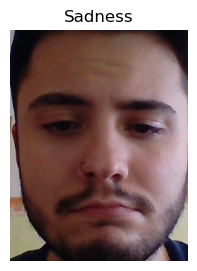

In [3]:
fpath = '../test_images/lucas/WIN_20221129_14_13_35_Pro.jpg'

ProcessFrame(fpath)

../test_images/AffectNet-HQ/fear/
env: CUDA_VISIBLE_DEVICES=0
Cuda:  False
0 ../test_images/AffectNet-HQ/fear//image0000284.jpg
Score cara 1:  [-1.1238481  -0.30506432  1.6158452  -0.7818862   0.00326734 -2.2160532
  1.5142559 ]


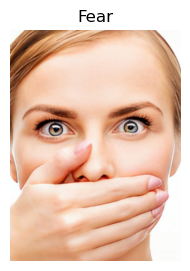

1 ../test_images/AffectNet-HQ/fear//image0000285.jpg
Score cara 1:  [ 1.3608737   0.10716142 -0.82415015 -2.103165    0.6829951  -0.29857132
  0.3460034 ]


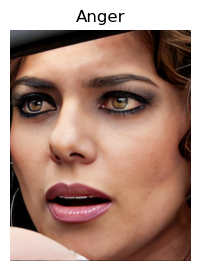

2 ../test_images/AffectNet-HQ/fear//image0000419.jpg
Score cara 1:  [-2.417803    0.84180176  1.9553059  -1.3149823  -1.3655741   2.1433818
 -1.0694602 ]


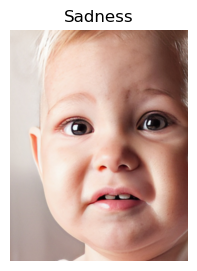

3 ../test_images/AffectNet-HQ/fear//image0000451.jpg
Score cara 1:  [-0.33226538  0.75981337 -0.54082346 -1.5426959  -0.14065151  1.9151176
 -1.2492943 ]


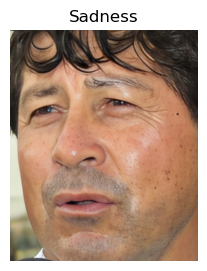

4 ../test_images/AffectNet-HQ/fear//image0000473.jpg
Score cara 1:  [ 0.642607   -1.3358496   2.362341   -2.984817   -0.28692228 -0.4981648
  0.1736926 ]


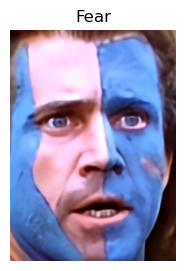

5 ../test_images/AffectNet-HQ/fear//image0000694.jpg
Score cara 1:  [-1.6771779  -0.8549188   0.02380915  0.28846657  0.6066784  -0.28467163
  1.3127506 ]


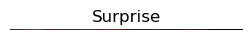

6 ../test_images/AffectNet-HQ/fear//image0000701.jpg
Score cara 1:  [ 1.8960888   0.4781686   0.61093014 -2.0377746  -0.08269463 -1.05014
 -1.3475883 ]


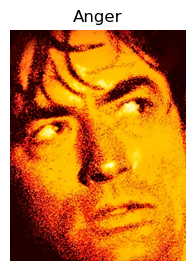

7 ../test_images/AffectNet-HQ/fear//image0000777.jpg
Score cara 1:  [-1.2663835  -0.58502644  2.813055   -2.236088   -0.5764223  -0.9949696
  1.04807   ]


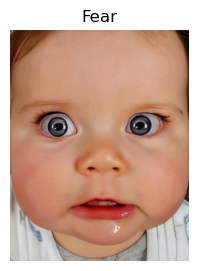

8 ../test_images/AffectNet-HQ/fear//image0000808.jpg
Score cara 1:  [ 1.0872464  -1.6245812   1.3050649  -0.04058784 -1.4632589  -0.07584284
  0.35292554]


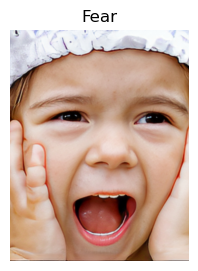

9 ../test_images/AffectNet-HQ/fear//image0000815.jpg
Score cara 1:  [-1.966939   -1.4550118   2.4732113  -2.4321697   0.75215167 -1.1156781
  2.254919  ]


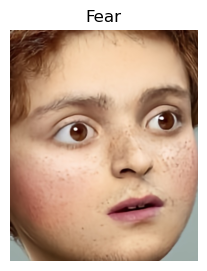

10 ../test_images/AffectNet-HQ/fear//image0000842.jpg
Score cara 1:  [-2.19572   -2.4473498  2.3139596 -0.2919958  0.675398  -1.0881826
  1.9977114]


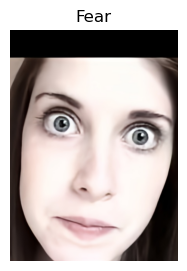

11 ../test_images/AffectNet-HQ/fear//image0000843.jpg
Score cara 1:  [-0.83439004 -0.18619382  4.526707   -4.5104628  -2.597945    0.666256
 -0.49189395]


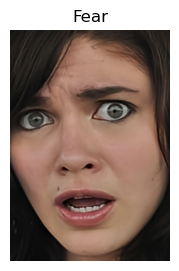

12 ../test_images/AffectNet-HQ/fear//image0000915.jpg
Score cara 1:  [-0.5903539 -2.5140336  4.4340005 -3.513322  -1.7266797 -3.3117387
  4.2475243]


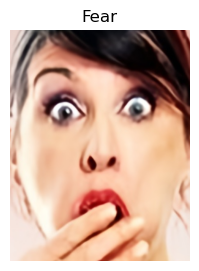

13 ../test_images/AffectNet-HQ/fear//image0001001.jpg
Score cara 1:  [-1.1508902 -2.478983   2.1726797  2.359833  -2.5594313 -3.3834743
  3.5297134]


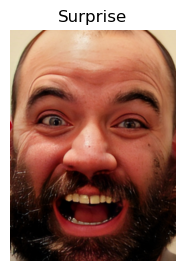

14 ../test_images/AffectNet-HQ/fear//image0001038.jpg
Score cara 1:  [-0.15675104 -1.0281409   0.379125   -1.2184671   1.3675864   2.8237865
 -1.556271  ]


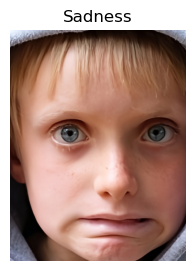

15 ../test_images/AffectNet-HQ/fear//image0001247.jpg
Score cara 1:  [-0.24091555 -1.492409    0.20425692 -1.9636285   1.8832568   1.0761348
  0.06531001]


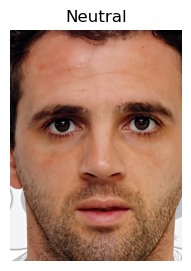

16 ../test_images/AffectNet-HQ/fear//image0001286.jpg
Score cara 1:  [ 1.4743234e+00 -3.6080396e-01  4.3760209e+00 -3.0972459e+00
 -4.4637499e+00  2.0071063e-03 -1.0273070e+00]


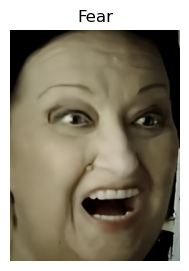

17 ../test_images/AffectNet-HQ/fear//image0001316.jpg
Score cara 1:  [-1.7669444  -0.1892559   3.6502676  -2.4831042  -1.3870183   0.46919003
 -0.5223502 ]


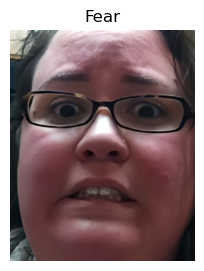

18 ../test_images/AffectNet-HQ/fear//image0001434.jpg
Score cara 1:  [-2.0444543  -0.97980887  0.32311946  0.30194592  0.40607125  0.31457767
  1.0010494 ]


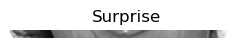

19 ../test_images/AffectNet-HQ/fear//image0001454.jpg
Score cara 1:  [ 0.78360176 -0.82283825  1.538226   -2.956888   -0.5773454  -0.90670484
  1.0394708 ]


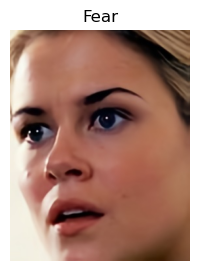

20 ../test_images/AffectNet-HQ/fear//image0001458.jpg
Score cara 1:  [ 0.5672824 -1.7173966  3.597932  -3.9238913 -1.606485  -2.078187
  2.1928847]


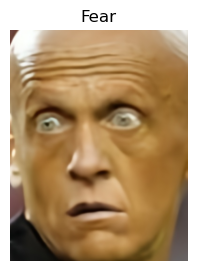

In [4]:
fpath = '../test_images/AffectNet-HQ/fear/'

ProcessFrame(fpath)

../test_images/WIN_20221201_19_23_14_Pro.mp4
frames per second = 29.833423850371616
env: CUDA_VISIBLE_DEVICES=0
Cuda:  False
Score cara 1:  [ 0.1893682 -3.7024994 -2.8133366  3.4325774  4.88117    2.219281
 -0.7490442]


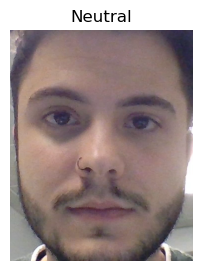

Score cara 1:  [ 0.6584619 -2.5713727 -1.3481145 38.15029   13.446597   6.225959
 16.34897  ]


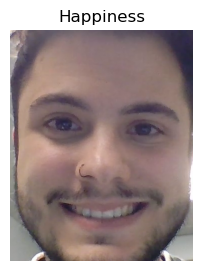

Score cara 1:  [-0.06245542 -0.17497906 -2.3553476   0.8759059   2.552573    2.6043992
 -1.8705957 ]


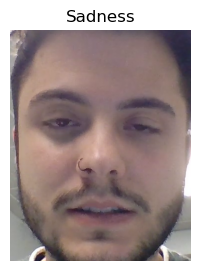

Score cara 1:  [-1.469076   -1.8832248   0.5420539  -1.6181282   1.345765    3.5193028
 -0.41857433]


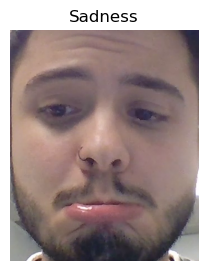

Score cara 1:  [-2.6935585 -2.9771798  3.6646447 -1.6465265 -0.6480957 -1.5831865
  3.6550515]


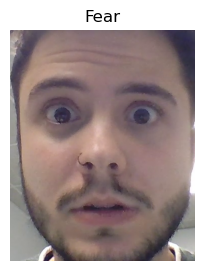

Score cara 1:  [-2.648204  -2.5132523  3.703223  -1.6879193 -1.0419062 -1.7665997
  3.6109416]


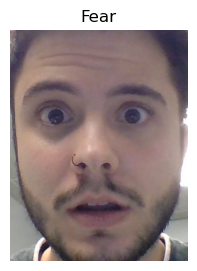

Score cara 1:  [-1.1840136  -1.9716544   1.6462231  -2.7207162   0.89599967  2.0858188
  0.1401499 ]


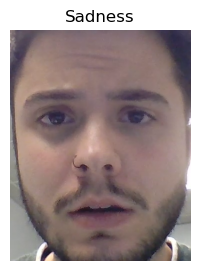

Score cara 1:  [ 3.4492736  0.7227188 -0.953903  -3.2194026  0.2887376  2.045443
 -3.2695484]


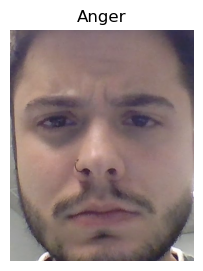

Score cara 1:  [ 1.8387862  -1.5912516   0.12208307 -2.702864    1.7852702   2.7389963
 -2.3704133 ]


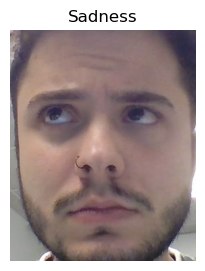

Score cara 1:  [ 0.08116768 -2.899842   -1.6519812   0.5760461   3.7859573   3.743008
 -1.4971824 ]


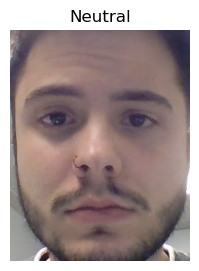

Score cara 1:  [ 3.4567788   1.9808531  -2.7694035  -1.2981097   0.67896414  0.91478205
 -3.2868333 ]


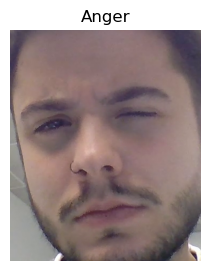

Score cara 1:  [  6.6835747   2.3908217 -10.498075   31.039892   15.577408   10.369092
   2.672316 ]


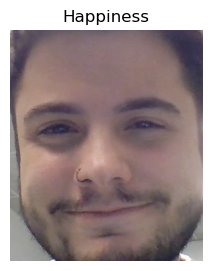

Score cara 1:  [ 0.48770404 -1.0426859  -5.1058393  10.509653    3.3389318   1.9720107
 -1.4281411 ]


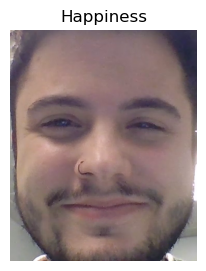

Score cara 1:  [-0.28835437 -0.45538348 -4.144795    5.513182    3.1637743   1.6671994
 -2.0505147 ]


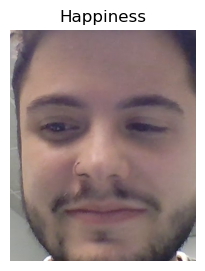

There is no image!


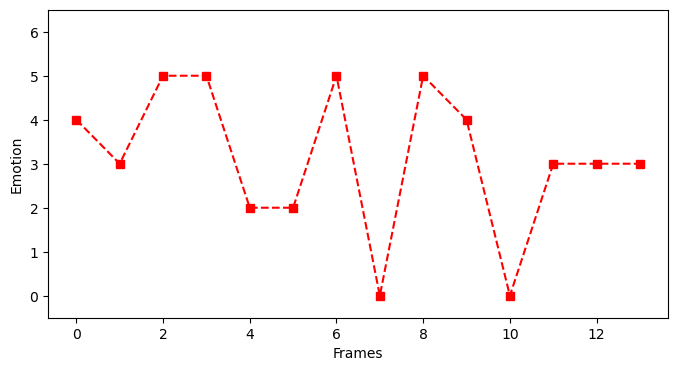

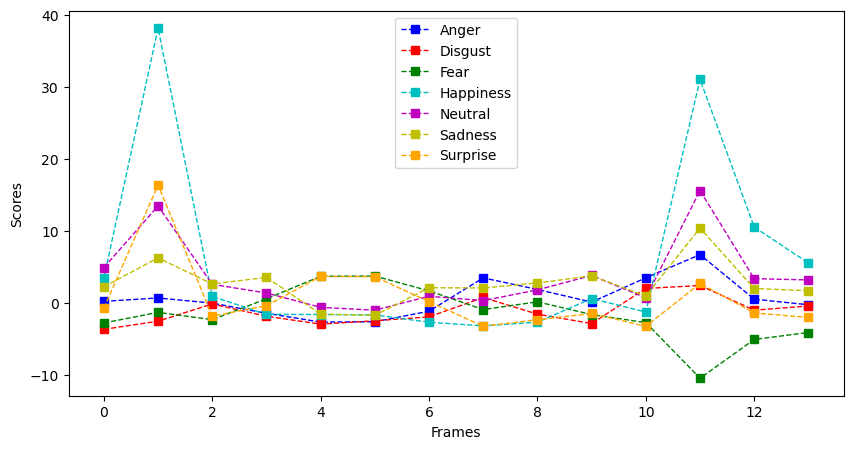

In [5]:
fpath = '../test_images/WIN_20221201_19_23_14_Pro.mp4'

ProcessFrame(fpath, want_plot=True)